In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
df = pd.read_csv(r'/Users/hiteshallakki/Downloads/course_lead_scoring.csv')

In [4]:
df.columns = df.columns.str.lower().str.replace(' ','_')

In [26]:
categorical_features = df.select_dtypes(include=['object']).columns
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
df[categorical_features] = df[categorical_features].fillna('NA')
df[numerical_features] = df[numerical_features].fillna(0)

In [18]:
strings = list(df.dtypes[df.dtypes == 'object'].index)
strings

['lead_source', 'industry', 'employment_status', 'location']

In [19]:
for col in strings:
    df[col] = df[col].str.lower().str.replace(' ','_')

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
df_full_train , df_test = train_test_split(df,test_size = 0.2 ,random_state =1)
df_train ,df_val = train_test_split(df_full_train , test_size = 0.25 ,random_state =1)

In [22]:
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [23]:
y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values

In [24]:
df_train = df_train.drop('converted',axis =1 )
df_val = df_val.drop('converted',axis =1 )
df_test = df_test.drop('converted',axis =1 )

In [43]:
#logistic regression 
numerical = list(df_train.dtypes[df_train.dtypes != 'object'].index)
numerical
categorical = list(df_train.select_dtypes(include=['object']).columns)



In [44]:
#confusion Table
categories

['lead_source', 'industry', 'employment_status', 'location']

In [49]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression


dv = DictVectorizer(sparse = False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical ].to_dict(orient = 'records')
X_val = dv.transform(val_dict)

#Training the model
model = LogisticRegression(solver = 'liblinear',C = 1.0 , max_iter = 1000)
model.fit(X_train,y_train)

y_pred = model.predict_proba(X_val)[:,1]

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_val,y_pred)

print (auc)

AUC: 0.817


In [52]:
#calculating ROC
aucs = {}

for var in numerical:
    scores = df_train[var].values
    auc = roc_auc_score(y_train,scores)
    if auc < 0.5:
        auc = roc_auc_score(y_train,-scores)
    aucs[var] = auc
    print(f"{var}: AUC = {auc:.3f}")

best_var = max(aucs,key =aucs.get)
print(f"best auc: {best_var}")

number_of_courses_viewed: AUC = 0.764
annual_income: AUC = 0.552
interaction_count: AUC = 0.738
lead_score: AUC = 0.614
best auc: number_of_courses_viewed


In [53]:
#precision and recall

/Users/hiteshallakki/Documents/DataTalks/jupyter_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hiteshallakki/Documents/DataTalks/jupyter_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hiteshallakki/Documents/DataTalks/jupyter_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

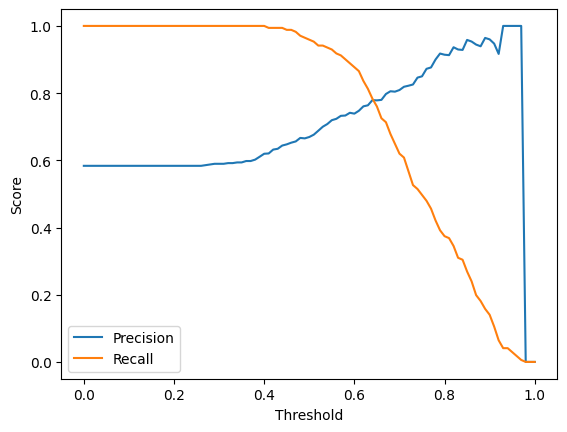

Precision and recall intersect at threshold: 0.640


In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
thresholds = np.arange(0.0,1.01,0.01)
precisions = []
recalls = []

for t in thresholds:
    preds = y_pred >=t
    p = precision_score(y_val,preds)
    r = recall_score(y_val,preds)
    precisions.append(p)
    recalls.append(r)
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

# find the intersection threshold
for t,p,r in zip(thresholds,precisions,recalls):
    if np.isclose(p,r,atol =0.01):
        print(f"Precision and recall intersect at threshold: {t:.3f}")
        break

/Users/hiteshallakki/Documents/DataTalks/jupyter_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hiteshallakki/Documents/DataTalks/jupyter_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hiteshallakki/Documents/DataTalks/jupyter_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

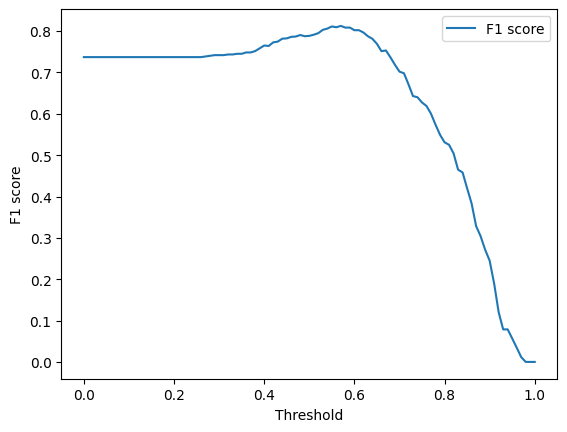

Max F1 score at threshold: 0.57


In [60]:
from sklearn.metrics import precision_score, recall_score

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    preds = y_pred >= t
    p = precision_score(y_val, preds)
    r = recall_score(y_val, preds)
    if p + r == 0:
        f1 = 0
    else:
        f1 = 2 * p * r / (p + r)
    f1_scores.append(f1)

plt.plot(thresholds, f1_scores, label='F1 score')
plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.legend()
plt.show()

max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
print(f"Max F1 score at threshold: {max_f1_threshold:.2f}")

In [63]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx].reset_index(drop=True)
    df_val = df_full_train.iloc[val_idx].reset_index(drop=True)

    y_train = df_train['converted'].values
    y_val = df_val['converted'].values

    train_dict = df_train[categorical + numerical].to_dict(orient='records')
    val_dict = df_val[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dict)
    X_val = dv.transform(val_dict)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('AUC scores per fold:', [round(s, 6) for s in scores])
print('Standard deviation of AUC scores: %.6f' % np.std(scores))

AUC scores per fold: [np.float64(0.806075), np.float64(0.871374), np.float64(0.775432), np.float64(0.801837), np.float64(0.855827)]
Standard deviation of AUC scores: 0.035807


In [70]:
def train_and_evaluate(df, C, categorical, numerical):
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    auc_scores = []

    for train_idx, val_idx in kf.split(df):
        train, val = df.iloc[train_idx], df.iloc[val_idx]
        y_train, y_val = train['converted'], val['converted']

        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(train[categorical + numerical].to_dict('records'))
        X_val = dv.transform(val[categorical + numerical].to_dict('records'))

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        y_pred = model.predict_proba(X_val)[:, 1]
        auc_scores.append(roc_auc_score(y_val, y_pred))

    return np.mean(auc_scores), np.std(auc_scores)


Cs = [0.000001, 0.001, 1]
results = []

for C in Cs:
    mean, std = train_and_evaluate(df_full_train, C, categorical, numerical)
    results.append((C, mean, std))
    print(f"C={C}: mean={mean:.3f}, std={std:.3f}")

best_result = results[0]
for result in results[1:]:
    C, mean, std = result
    if (mean > best_result[1]) or (mean == best_result[1] and std < best_result[2]):
        best_result = result

best_C = best_result[0]
print(f"Best C: {best_C}")

C=1e-06: mean=0.560, std=0.024
C=0.001: mean=0.867, std=0.029
C=1: mean=0.822, std=0.036
Best C: 0.001
